<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analysis-of-RSS-Feed-Content-with-Topic-Identification" data-toc-modified-id="Analysis-of-RSS-Feed-Content-with-Topic-Identification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analysis of RSS-Feed Content with Topic Identification</a></span><ul class="toc-item"><li><span><a href="#Initialization-and-Parametrization" data-toc-modified-id="Initialization-and-Parametrization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialization and Parametrization</a></span></li><li><span><a href="#Data-Collection" data-toc-modified-id="Data-Collection-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Collection</a></span><ul class="toc-item"><li><span><a href="#Operation-as-RSS-Aggregator" data-toc-modified-id="Operation-as-RSS-Aggregator-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Operation as RSS Aggregator</a></span></li><li><span><a href="#Loading-Previously-Pickled-RSS-Feeds" data-toc-modified-id="Loading-Previously-Pickled-RSS-Feeds-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Loading Previously Pickled RSS Feeds</a></span></li></ul></li><li><span><a href="#Overview-of-Feed-Data" data-toc-modified-id="Overview-of-Feed-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Overview of Feed Data</a></span><ul class="toc-item"><li><span><a href="#Article-Sizes" data-toc-modified-id="Article-Sizes-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Article Sizes</a></span></li><li><span><a href="#Overview-of-Article-Authors" data-toc-modified-id="Overview-of-Article-Authors-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Overview of Article Authors</a></span></li><li><span><a href="#Tags-Specified-by-the-Feed-Publishers" data-toc-modified-id="Tags-Specified-by-the-Feed-Publishers-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Tags Specified by the Feed Publishers</a></span></li></ul></li><li><span><a href="#Identifying-Topics-within-the-Articles" data-toc-modified-id="Identifying-Topics-within-the-Articles-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Identifying Topics within the Articles</a></span></li><li><span><a href="#Using-Soft-Cosine-Similarity-to-Cluster-Stories" data-toc-modified-id="Using-Soft-Cosine-Similarity-to-Cluster-Stories-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Using Soft Cosine Similarity to Cluster Stories</a></span><ul class="toc-item"><li><span><a href="#LDA-Analysis-with-the-pyLDAvis-Visualization" data-toc-modified-id="LDA-Analysis-with-the-pyLDAvis-Visualization-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>LDA Analysis with the pyLDAvis Visualization</a></span></li></ul></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Sentiment Analysis</a></span></li></ul></li><li><span><a href="#Content-Viewer" data-toc-modified-id="Content-Viewer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Content Viewer</a></span><ul class="toc-item"><li><span><a href="#A-Technical-Correction" data-toc-modified-id="A-Technical-Correction-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A Technical Correction</a></span></li></ul></li></ul></div>

# Analysis of RSS-Feed Content with Topic Identification

## Initialization and Parametrization

Initially the functions for data-scraping, loading and summarizing are loaded

In [1]:
%load_ext autoreload
%autoreload
import importlib
%aimport reader
from reader import (loadAllFeedsFromFile, summarizeItems,getFeedDict, 
                    collectArticles, summarizeByDate, summarizeFeeds, smallDict)

The user can specify in the following block global parameters which are, per default, used in running the scripts in this notebook. Typical usage and variants on the default parameters are hinted at in the commented code.

In [2]:
runParams={'allFeeds':       getFeedDict(),   # A collection of 50 URLs for RSS Feeds, where the names can be chosen freely
                                              # example: {'Buzzfeed': 'https://www.buzzfeed.com/world.xml', 
                                              #           'Al Jazeera': 'http://www.aljazeera.com/xml/rss/all.xml'}
           'inputDir':       './data',        # Directory containing pre-collected RSS-Feed data in pickle format
           'articleLimit':   500,             # Optional specification limiting number of articles to process (for test
                                              # purposes only)
           'numAuthDispl':   30,              # specify limit of number of authors to display/plot
           'numTagsDispl':   30,              # specify limit of number of tags to display/plot
           'numTopics':      30,              # specify limit of number of topics to be found via TFIDF Vectorization
           'numLDATopics':   20,              # specify limit of number of topics to be found via Latent Dirichlet Allocation 
           'numTopicsDispl': 30,              # specify limit of number of topics to display/plot
           'removeTopics':   True,            # specify if articles now referenced by topics should be removed (saves 
                                              # computation time later)
           'ngramRange':     (3,3),           # define min and max ngrams as tuple for deriving topic maps 
           'weModel':        'glove-wiki-gigaword-50', # Word Embedding model for soft cosine similarity calculation
                                              # options are e.g. glove-wiki-gigaword-50,fasttext-wiki-news-subwords-300
                                              # CAUTION: although higher dimension models produce more nuanced results, load
                                              # times are VERY long. In particular the first time use requires a download of
                                              # massive amounts of data which can easily take as much as an hour
           'thresholdFuzzy': 50,              # define cut-off threshold for fuzzy (Levenshtein Distance comparison) in percent
           'thresholdCosine':0.6,             # define cut-off threshold for soft cosine similarity as fraction (0.0 to 1.0)
           'fuzzyDocLimit':  None,            # optional integer limit to number of articles used for fuzzy relevance of
                                              #topics (only for test purposes: default None) 
           'matrixDir':      './outdata',     # relative path for saving matrices to file
           'saveMatrix':     False}           # whether to save matrix to file or not

## Data Collection

Data is collected from a wide range of RSS-Feeds..

A large number of names and URLs of compatible feeds are pre-defined in the convenience function getFeedDict. These feeds have been pre-configured for the usage in this project. For example CNN only supplied links to the stories. With more elaborate techniques one could go to the corresponding article site and scrape the site for the content. Due to time limitations and enough material provided CNN was not included. 

The user may however supply his/her own dictionary of feeds for subsequent processing. In the next field an overview is given of the feeds that will used in this project. 

In [3]:
summarizeFeeds(runParams['allFeeds'])

,Source,Feed
0,Africa Launch Pad,https://africalaunchpad.com/feed/
1,Al Jazeera,http://www.aljazeera.com/xml/rss/all.xml
2,Annals Hub,https://annalshub.com/feed/
3,Article IFY,https://articleify.com/feed/
4,BBC News,http://feeds.bbci.co.uk/news/rss.xml
5,Baltic World,https://balticword.eu/feed/
6,Buzzfeed,https://www.buzzfeed.com/world.xml
7,CNBC,https://www.cnbc.com/id/100727362/device/rss/rss.html
8,Christian Science Monitor,https://rss.csmonitor.com/feeds/world
9,Daily CN News,https://dailycnnews.com/feed/


For the purposes of reducing running time, the analyses will continue with a smaller subset of feed data. For a complete analysis the next cell can be commented out.

In [4]:
%%time
collectArticles(runParams['allFeeds']) 

NY Times
Buzzfeed
Al Jazeera
Defence Blog
Global Issues
The Cifer Brief
Yahoo
Times of India
The Guardian
CNBC
RT
Reuters
Der Spiegel
Vox
Time Magazine
UN
BBC News
The Independent
The Sun
South China Morning Post
State Department
Christian Science Monitor
PRI
Eastern Herald
New Europe
News Blaze
Small Wars
Headline Code
Article IFY
Times in Plain English
World Weekly News
Annals Hub
Z6 Mag
HGS Media Plus
The Next Hint
Africa Launch Pad
International Security Journal
NewsZetu
IT World
Baltic World
World Affairs Journal
Zemo City
Newzit News
Patriot Rising
Daily CN News
World United News
Nedu Wealth
Vivian Violine's blog
Global Vision UK
Just World News




Wall time: 1min 5s


'data/feed30052020_232532.pickle'

### Operation as RSS Aggregator

The collected feeds are automatically stored in pickle files, which can be accumulated over time or discarded if unneeded. This method was used as a rudimentary RSS aggregator for a period of weeks for collection of RSS articles, a technique necessary, since many RSS feeds only publicize a very small number of articles at any given time. 

In this project the collection was simply done manually without any automated collection techniques, which would be appropriate in a larger project. Pickle was able to retain the structure of the data, which worked better than the attempts made using JSON for serialization. Pickle being a binary format has the advantage of being more efficient and the disadvantage of not being human-readable.   

### Loading Previously Pickled RSS Feeds

The function loadAllFeedsFromFile simply loads all previously pickled dictionaries from the configured directory. For smaller test runs the user may simply remove some of the larger test files from this directory. A consistent test run is possible even with quite small amounts of data, although the significance of the results will of course be diminished.

In [3]:
allDict=loadAllFeedsFromFile(path = runParams['inputDir'], limitsize=runParams['articleLimit'])

loading file:  ./data\corpus11100articles.pickle
loading file:  ./data\feed30052020_224714.pickle
loading file:  ./data\feed30052020_231016.pickle
loading file:  ./data\feed30052020_232532.pickle


## Overview of Feed Data

Let's take a look at the data we have. Below the source, the title and the content has been listed. In subsequent analyses the title was combined with the content in order to provide a larger amount of data. The RSS news articles don't all have content, other RSS feeds only provide a summary. The articles are cleaned from HTML-tags and saved to item with the key collatedContents in each entry. This also causes varying article sizes. This effect can be viewed in the box plot below. 

In [4]:
summarizeItems(allDict)

### Article Sizes

Let's take a look at the sizes of the articles over time and from the various feeds. As can be viewed in the box plot the article size varies greatly with a lot of articles only up to a 1000 words. With a large amount of collected articles being summaries this finding is not surprising.

Articles were dated from the 2nd of May until the 22nd, older articles predating the start of the project were dismissed especially due to some some sources dating back a lot further than others, notably the New York Times daily briefings are removed, as they skew topics/clustering whilst having almost no content. Since the data is from news feeds, older articles are not always available as a characteristic of news feeds is being up to date.

Thus, if deleteBadEntries is specified, then additionally all entries without Content or summary_detail are removed from the supplied allEntryDict, as are legacy articles older than the start of project (see: dateOlderThan function in the code). 

It can be concluded that the size of the articles is constant and not increasing over time.



Wall time: 7.66 s


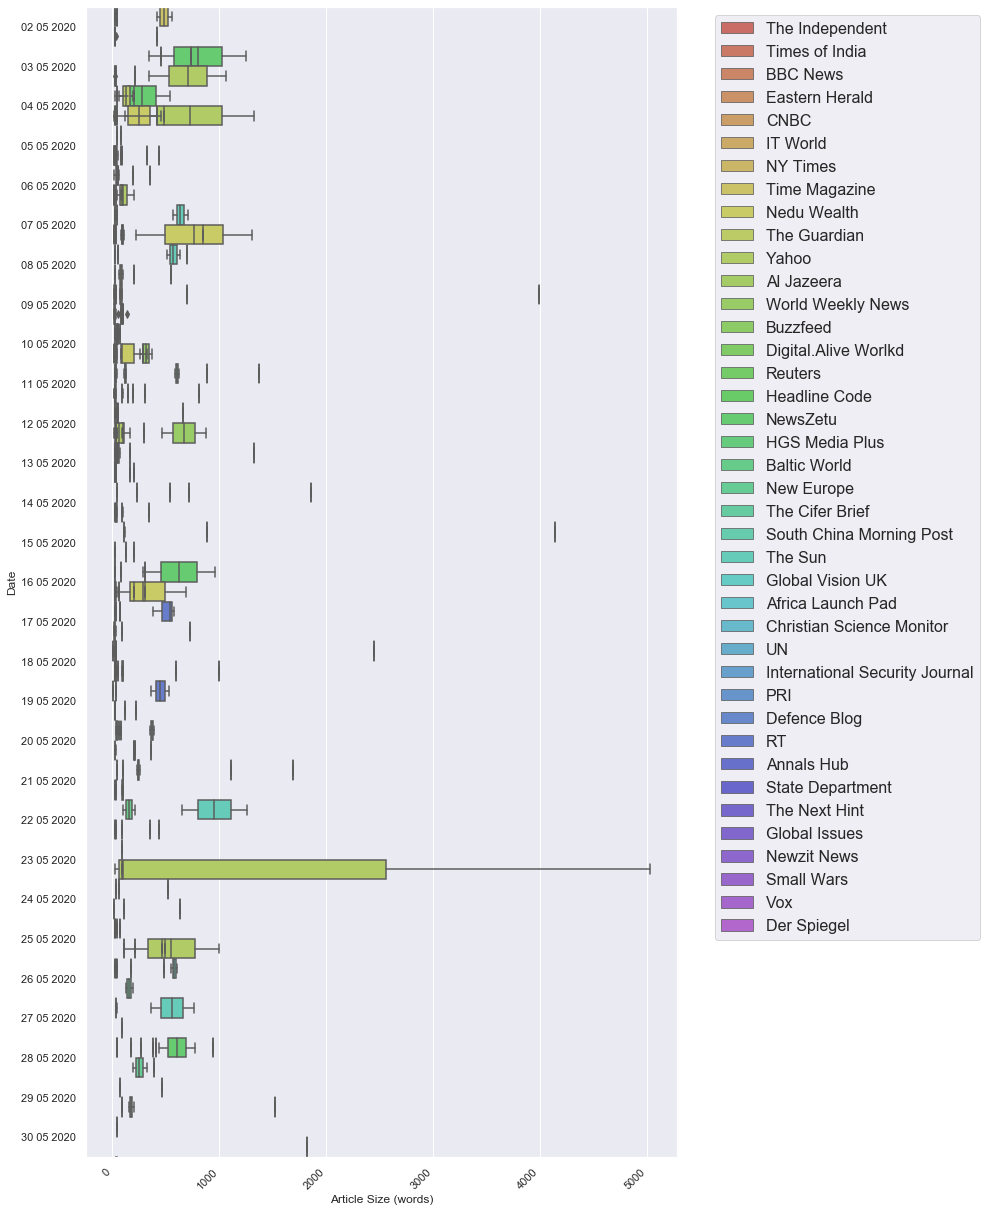

In [5]:
%%time
summarizeByDate(allDict)

### Overview of Article Authors

For the purpose of plotting the articles a Python library called "seaborn" was used, also in order to create a certain uniformity in displaying plots.

In [6]:
#importlib.import_module("samples.seabornScatterPlots") # TODO move to base directory, not samples
%aimport scatterplots 
#importlib.reload(scatterplots)
from scatterplots import displayTopics,displayAuthors,displayTags

C:\Users\Janice\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In the data that was analysed there have been a significant amount of articles without authors. As can be viewed in the plot below there are a significant amount of articles that have as an author more general descriptions, such as "admin" or "author". 

Often news sources also refer directly to news agencies being authors of articles like "Associated Press" and "Agence France-Presse" and "Reuters" or even the Russian News Network "RN", indicating a higher transparency where their news is from.

Some feeds have their own notation, which due to time constraint and importance of this issue when interpreting articles, were not converted most notably, "&#124;" which consists of the "&#" and "124" with ";" resulting in the mark up language "EP&#124;NE" meaning that the article has the two authors EP and NE (who the people behind the abbreviations are is not disclosed).

With author: 302 Without author: 198


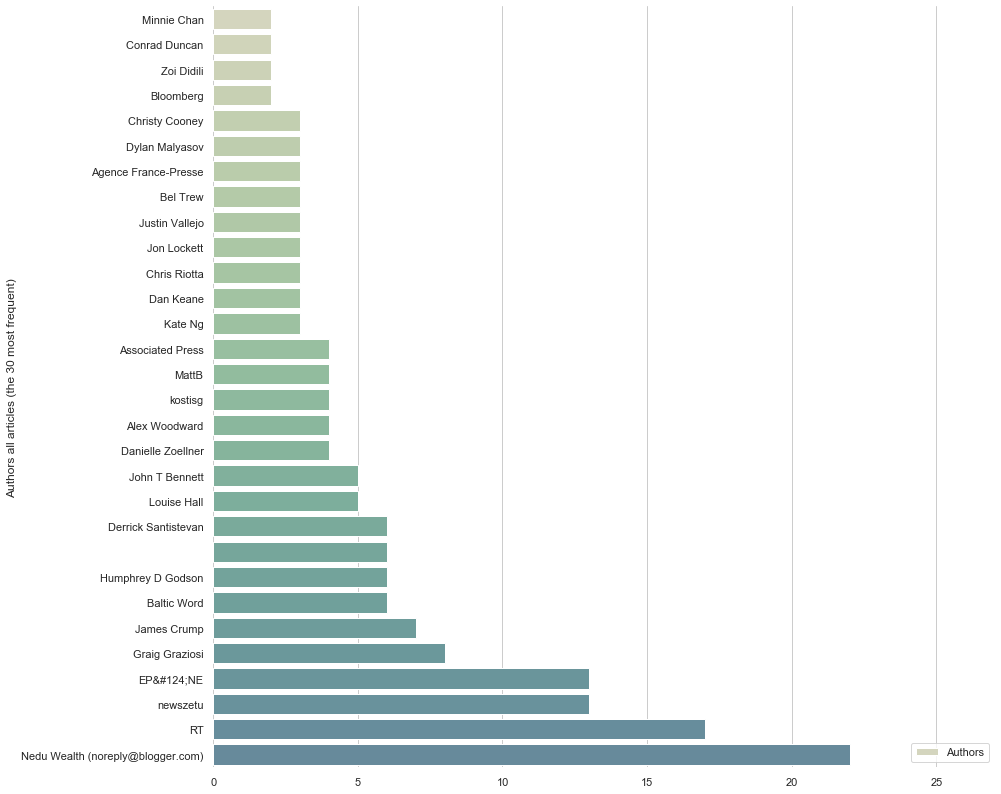

In [7]:
displayAuthors(dict=allDict, displayAmount=runParams['numAuthDispl'])

### Tags Specified by the Feed Publishers

Below two seaborn plots are displayed concerning the tags that were used by news articles. Tags are frequently used when people are searching for news articles. As such they usually are more general in nature and should be able to be provide a source in order to group articles. As displayed below there are however still a few different descriptions of tags referring to the same topics. 

A prime example of how different tags refer to the same talking point is the corona virus pandemic, tags "COVID-19", "Covid-19 Pandemic", "Coronavirus outbreak" and "Coronavirus" all refer to the same topic.

It also has to be noted here as the articles were collected in the timespan of the 2nd to the 22nd of May 2020 the world has been gripped by the corona virus pandemic. And as such the tag usage in the feeds in the plot below shows very big bubble denoting the importance of the virus. It also has to be mentioned that the pandemic has influenced wide varieties of news and as such covid has been mentioned a lot in combination with other tags, further increasing its usage.

Some news providers also use tags more in general such as The Guardian tending to employ many more tags than, for instance, Daily CN News.

In the code below it has been specified to show the 20 most common tags, this is a parameter that can be adjusted to display more or less by the reader. Additionally, the data refers to "allDict", which is the dictionary of collected articles that are used in the analysis of this project. This of course can be changed to for instance an own dictionary provided by the reader.

From allDocDict how many of the specified tags occur is calculated for each FeedItem of the named feeds in feedTagMatrix, summing them in the x.y position (Feed, Tagname) in the given matrix below. Specify more output using the displayAmount parameter, if you wish.


There were 195 articles with tags and 305 without tags


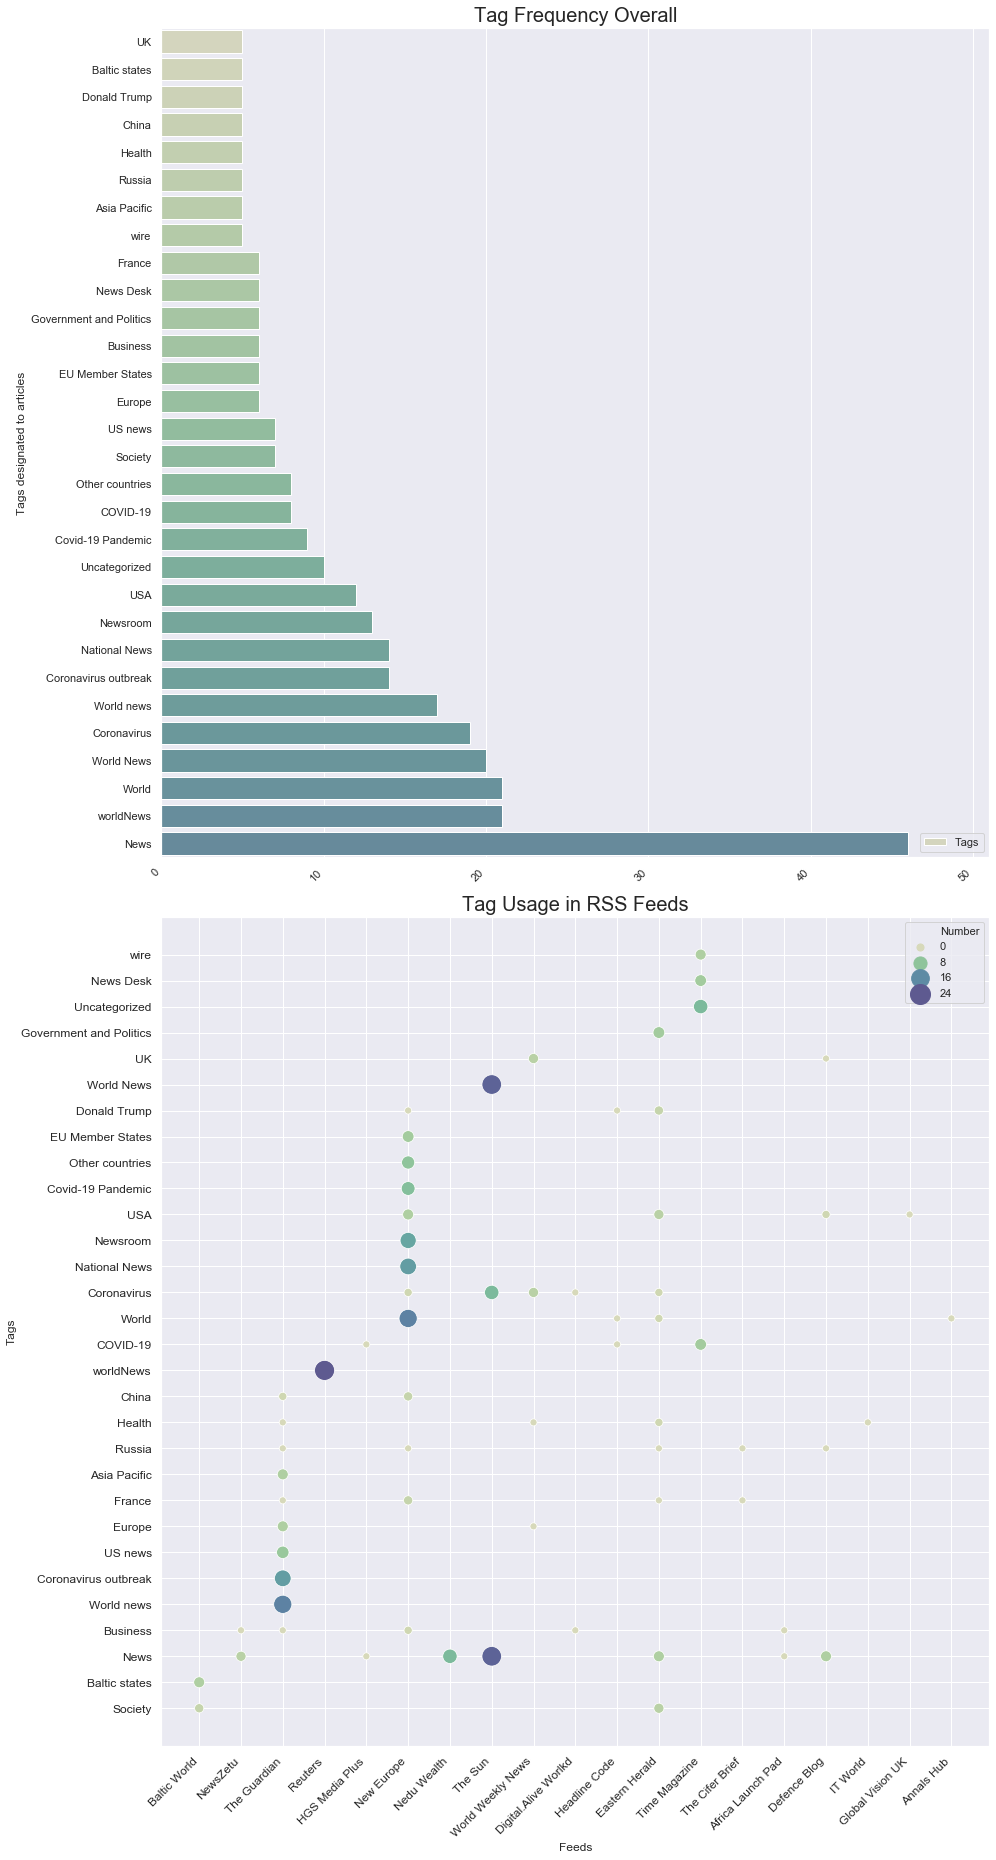

In [8]:
%aimport scatterplots
#importlib.reload(scatterplots)
from scatterplots import displayTags
displayTags(allDict, displayAmount=runParams['numTagsDispl'])

## Identifying Topics within the Articles

In [9]:
%aimport topicmap
#importlib.reload(topicmap)
from topicmap import (displayTopicsAndFeeds,getDocList, getAllTopics,getCustomStopWords, deriveTopicMaps, 
                      updateDictionaryByFuzzyRelevanceofTopics, doStandardInitialize,getAllFeedTopics)

In the next piece of code the docContentList is defined by the "allDict" (i.e. the collected articles held in a dictionary) and the "stop_list". Both of these elements can be changed for individual purposes. The stop_list refers to an individual list of custom stop words. Stop_list refers to the expressions (stop words and phrases) that need to be ignored in addition to the nltk.corpus stoplist for English. NLTK ( Natural Language Toolkit) is another Python library that was used in the analysis for tokenization, stemming, tagging, parsing and semantic reasoning. An example of a stop phrase that was manually added would be "view entire post", which is not related to the content and occurs often enough that it could not be manually deleted from the analysed content. The interested user may wish to supply other stop word lists or extend the stop word lists used in this project, which are available from the function getCustomStopWords.

With added Lemmatization, the given number of "Topics" through maxNum is derived using TFIDF Vectorization from the supplied sentences. The implicit use of TfidfTransformer additionally scales down the impact of tokens that occur very frequently in the given corpus and that are hence empirically less informative than features occuring in a small fraction of the corpus. 

A very interesting parameter to experiment with is the ngram_range. The lower and upper bounds allow/restrict to topics with the number of words within the range to be derived from the corpus. With an ngram range of 1,1 only topics based on single words are found. Tests have shown this to produce large numbers of hits for with rather mundane every-day words. At the other extreme, tests with a range such as 7,8 seem to detect very tabloidesque stories, which raise the suspicion of been produced through syndication from a singe source. The most promising results were obtained with an ngram range of 3,3 or 3,4.

In [10]:
%%time
docContentList=getDocList(allDict, 
                          reloaddocs=False,
                          stop_list=getCustomStopWords())
topics= deriveTopicMaps(docContentList, 
                        maxNum=runParams['numTopics'], 
                        ngram_range=runParams['ngramRange'])


Wall time: 8.26 s


The Function updateDictionaryByFuzzyRelevanceofTopics adds a list of topic/weighting tuples to each entry of the given allDict for each topic that has a fuzzy relevance (the Levenshtein Distance is calculated between the topic phrase and the content of each RSS-entry) of greater than the specified threshold, which can be changed here, as required.
The fuzzy string comparison that was applied here, analyzes similar instances of  topics thus reducing the amount of topics that are analysed and ultimately displayed below. 

For the purpose of the Levenshtein Distance comparison the python package "fuzzywuzzy.python" (https://github.com/seatgeek/fuzzywuzzy) was used.



There were 365 items with topics and 0 without topics


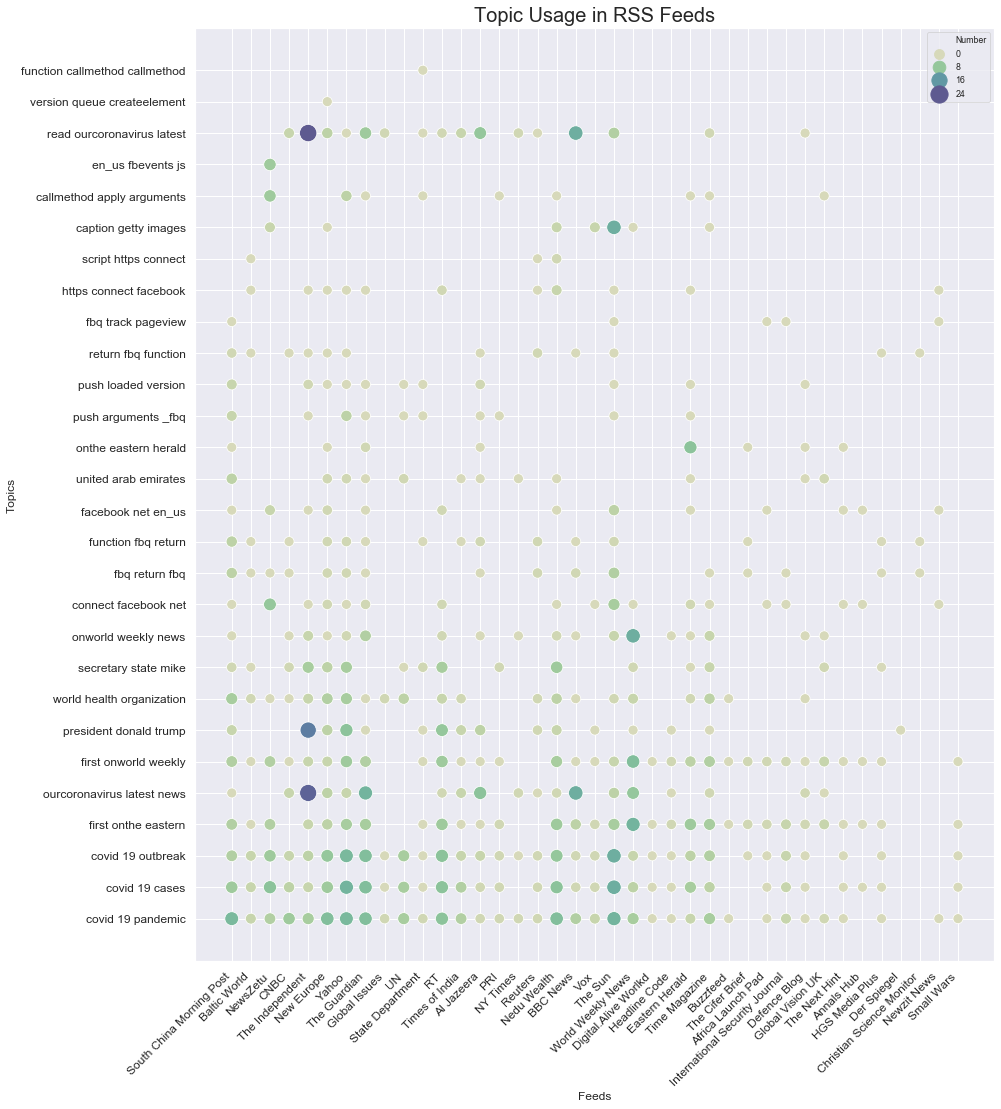

Wall time: 1min 28s


In [11]:
%%time
updateDictionaryByFuzzyRelevanceofTopics(topics,
                                         allDict, 
                                         limit=runParams['fuzzyDocLimit'], 
                                         threshold=runParams['thresholdFuzzy'],
                                         remove=runParams['removeTopics'])
displayTopicsAndFeeds(allDict, 
                      numTopics=runParams['numTopicsDispl'])

The scatter plot up above describes the distribution of detected topics for each feed. As is evident from the above, the topics "new coronavirus cases" and "latest updates see coronavirus" refer to the corona virus pandemic. As was already detected in the tags in a previous section, the corona virus has overwhelmingly dominated the news in the analysed month of May 2020. Particularly classical news feeds of BBC News and The Independent, which update their feeds often as opposed to Der Spiegel that usually posts more editorial pieces, post about the latest updates regarding the pandemic.   

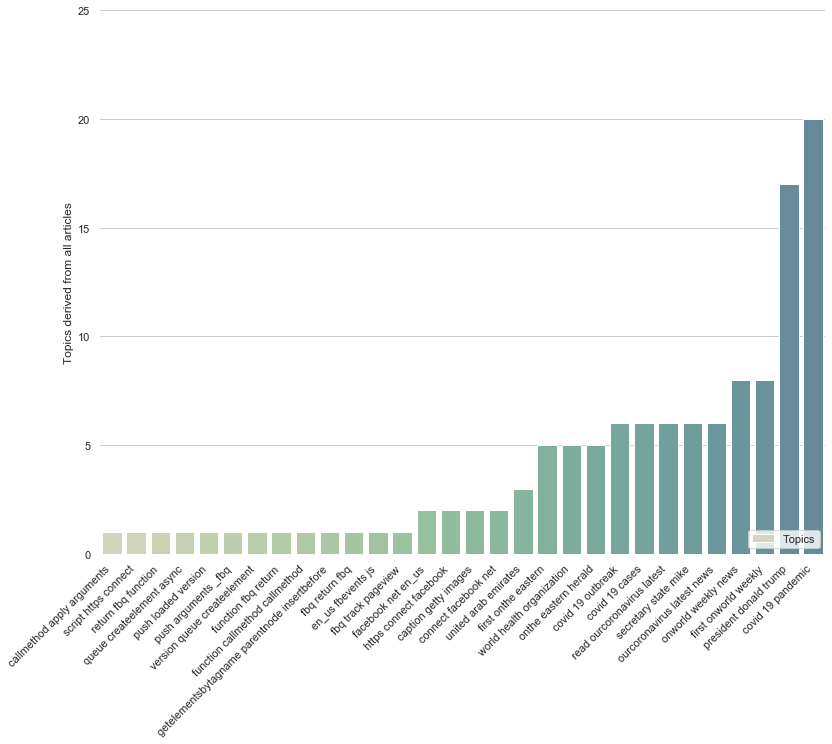

In [12]:
displayTopics(topics)

Clearly the overwhelmingly most prevalent topic (in May 2020) is the coronavirus pandemic (Covid-19). Not only as the main story of the day (and of the month and year), but also spurning dozens of other sub-stories emanating from the Covid-19 crisis. World War II is also mentioned as part of the topics, as this year marks the 75 anniversary on May 7 that Germany had signed the unconditional surrender marking the end of the war. Kim Jong Un was also derived as a separate topic since he missed his grandfather's birthday celebration (April 15th) and had not been seen in public for an extended period of time and has then reappeared in May 2020. These events have to be accounted for when analysing the the most recent news feed articles.  

## Using Soft Cosine Similarity to Cluster Stories

In the 3D scatter plot map below a similarity matrix is displayed. In order to do so the documents are collected from a file (which can be specified), a list of titles+content is taken as the basis to calculate 40 (in this case) topics using 3 to 4 n-grams. This can also be specified by the reader however 3 to 4 N-grams have found for this purpose to be the best in order to provide more context (e.g. "Korea" by its own is not enough to know if the news concerns "North Korea" or "South Korea" and why the country is mentioned).
The topics are then mapped and a list of topics is added to each entry of the given allEntryDict for each topic that has an LDA fuzzy relevance (see fuzzywuzzy process) of greater than the specified threshold.

The  SoftCosine-Similarity matrix is then calculated with WordEmbeddings fasttext_model300 (dimension 300) or alternatively GloVe (dimension 50). The first call for "fasttext" includes a download of ca. 1GB of data, which takes ca. 30 minutes, subsequent calls load this from disk, which also takes 2-3 minutes. Alternatively, the first call for "GloVe (w2v_model)" includes a download of ca. 60MB of data, which takes ca. 3 minutes, subsequent calls load this from disk which also takes 30 seconds. Thus. time to load this should be calculated when deciding to calculate the SoftCosine-Similarity matrix with a dimension of 300 or 50. 

The matrix is subsequently saved to file. A spectral analysis and dimension reduction (using the PCA method) is used on similarity matrix. Different methods of dimension reduction are also available, such as LDA, which is used below to show an alternative way. The matrix is then presented using plotScatter3D with tool tips.

Tool tips is an HTML string for displaying the RSS-entry infos, currently title, feedname, date of publication and author. What is displayed can be adjusted in the code according to what is required by the reader.

The sizes of the spheres in the plot are scaled to the degree of cosine similarity for the article in relation to the cluster.

In [13]:
%aimport similarity
importlib.reload(similarity)
from similarity import deriveSoftCosineSimilarityMatrix,do3DPlotOfCosineSimilarity ,showPyLDAvis, saveDFPickle, loadMatrixFiles

In [14]:
%%time
matrix=deriveSoftCosineSimilarityMatrix(allDict, weName=runParams['weModel'])
if (runParams['saveMatrix']):
    saveDFPickle(matrix, path=runParams['matrixDir']) 
    
# matrix can be reloaded later, if needed, using 
# matrixList=loadMatrixFiles(path=runParams['matrixDir']) <-- returns list


Wall time: 8min 9s


Now that the similarity matrix has been calculated it is very quick and easy to produce additional plots. For instance with a higher threshold, thus filtering out less significant articles or specifying a different number of topics to color-code.

In [15]:
do3DPlotOfCosineSimilarity(allDict,matrix=matrix,numTopics=runParams['numTopics'], threshold=runParams['thresholdCosine'])

And now here a further example with freely specified topic number and threshold:

In [16]:
do3DPlotOfCosineSimilarity(allDict,matrix=matrix,numTopics=20, threshold=0.45)

### LDA Analysis with the pyLDAvis Visualization

As was explained previously, there are different techniques available to generate the topics that are displayed. One option that is touched upon here is LDA or Latent Dirichlet Algorithm. LDA accounts for (as opposed to a Bag of Words approach) the interchangeability of words and strings. LDAvis as used below is a technique of interactively visualising multiple dimensions. The package is imported from the gensim library.

The most relevvant terms are displayed below. Moving the cursor over one of the terms shows the conditional distribution of the topic. Again the reader is able to specify the numTopics and the allDict that are used. 

In [17]:
%%time
#importlib.reload(reader)
#importlib.reload(similarity)
from similarity import showPyLDAvisNB
showPyLDAvisNB(allDict,numTopics=runParams['numLDATopics'])

Loading BokehJS ...

Wall time: 1min 13s


<Figure size 1008x1116 with 0 Axes>

The red bars in the interactive graphic above represent the estimated number of times a given term was generated by a given topic. It is almost impossible to find out what the context of the terms is, as the the terms used are single words thus bi-grams and other n-grams would provide a better overview of what exactly is meant.
The blue bars represent the overall frequency of the terms in each topic.

Thus, the term "us" is mentioned close to 400 times and when for instance topic number 8 is selected the estimated number of times a "us" was generated by topic 8 is about the 100 mark.  

The topic-term circles are proportional in size to the frequency with which a term is estimated to have been generated by the topics. Evidently topic-term
circles related to "health" are among of the largest circles generated. When a term is selected on the right hand side, the circle area changes in area to the
topic-term relative for that term. For example by hovering over the term "digital" the topic-term circle number 8 increase markedly.   

## Sentiment Analysis

In [18]:
%aimport sentiment
importlib.reload(sentiment)
from sentiment import displaySentiment3D
displaySentiment3D(allDict, topics)

Dropdown(description='Topic:', index=6, options=('callmethod apply arguments', 'caption getty images', 'connec…

# Content Viewer

With the following tool you can browse the contents of the corpus. Specifying a topic, all RSS-entries with even a minimal reference to that topic may be selected from the drop down list.

In [19]:
%aimport sentiment
importlib.reload(sentiment)
from sentiment import contentsViewer
contentsViewer(allDict, topics)

## A Technical Correction

Here a small hack to correct the width of the cells which seem to get disturbed by the pyLDAvis widget

In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))